## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os

import sinogap_module_fcBypass as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**6
    ,batchSplit = 2**6
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateG = 1e-3
    ,learningRateD = 1e-3
    ,dataDir = 'data'
)

sg.DCfg = sg.DCfgClass(8,False)


#os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, expose = 5e-3)
sg.trainLoader = sg.createDataLoader(sg.trainSet, num_workers=sg.TCfg.num_workers)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive = True)
sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=sg.TCfg.num_workers)

['data/18692a.ExpChicken6mGyShift', 'data/23574.8965435L.Eiger.32kev_sft', 'data/19022g.11-EggLard', 'data/18692b.MinceO', 'data/23574.8965435L.Eiger.32kev_org', 'data/19736b.09_Feb.4176862R_Eig_Threshold-4keV', 'data/20982b.04_774784R', 'data/18515.Lamb1_Eiger_7m_45keV_360Scan', 'data/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1', 'data/18692b_input_PhantomM', 'data/21836b.2024-08-15-mastectomies.4201381L.35kev.20Hz', 'data/23574h.9230799R.35kev', 'data/18515.Lamb4_Excised_Eiger_7m_30keV_360Scan.Y1', 'data/18648.B_Edist.80keV_0m_Eig_Neoprene.Y2', 'data/19932.10_8093920_35keV', 'data/19932.14_2442231_23keV', 'data/19932.16_4193759_60keV']
Loading train set 1 of 17: data/18692a.ExpChicken6mGyShift ... Done
Loading train set 2 of 17: data/23574.8965435L.Eiger.32kev_sft ... Done
Loading train set 3 of 17: data/19022g.11-EggLard ... Done
Loading train set 4 of 17: data/18692b.MinceO ... Done
Loading train set 5 of 17: data/23574.8965435L.Eiger.32kev_org ... Done
Loading train set 6 of 17: 

### <font style="color:lightblue">Show</font>

In [5]:
sg.examples = [
    ((3, 476, 2880), 0.78),
    ((2, 118,  988), 0.89),
    ((0, 336, 645), 0.725),
    ((3, 925,  592), 0.35)
]

sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 0)
#sg.showMe()
#sg.displayImages()


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [ ]:
def unrollArch2(gen) :
    gen.encoders =  nn.ModuleList([
        *gen.encStep(1,2,header=True),
        *gen.encStep(2,4),
        *gen.encStep(4,8),
        ])
    gen.fcLink = gen.createFClinkS()
    gen.decoders = nn.ModuleList([
        *gen.decStep(8,4),
        *gen.decStep(4,2),
        *gen.decStep(2,1, footer=True),
        ])
    gen.lastTouch = gen.createLastTouch()


class DBricksGenerator2(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator2, self).__init__(2, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = None
        self.baseChannels = 32
        unrollArch2(self)
        #sg.load_model(self, model_path="model_2_gen.pt" )


class StripeGenerator2(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator2, self).__init__(2, False, batchNorm=True)
        self.lowResGenerator = None
        self.baseChannels = 8
        unrollArch2(self)


class Generator2(sg.GeneratorTemplate) :
    def __init__(self):
        super(Generator2, self).__init__(2, batchNorm=True, inChannels=2)
        self.brickGenerator = DBricksGenerator2()
        self.stripeGenerator = StripeGenerator2()
        self.createBricksMask()
        #sg.load_model(self, model_path="tmp.pt" )
        #sg.load_model(self, model_path="model_3_gen.pt" )

    # For historical reasons, this generator was trained differently.
    # One day I will retrain it and remove this forward function.
    def forward(self, images):
        # prepare input
        images = images.clone().detach()
        preImages, preMid = self.preFill(images)
        images[:,[0],*self.cfg.gapRng] = preImages[:,[0],*self.cfg.gapRng]
        images, norms = sg.normalizeImages(images)
        # prepareStripe
        stripeImages, mid = self.stripeGenerator.forward(images, preMid)
        # refolded images into bricks
        bricksOrg = self.stripe2bricks(images)
        bricksStr = self.stripe2bricks(stripeImages)
        # generate bricks
        modelIn = torch.cat( [ bricksOrg, bricksStr ], dim=1 )
        bricksOut = self.brickMask * self.brickGenerator.forward(modelIn)[0]
        stripesOut = self.bricks2stripe(bricksOut)
        # combine channels
        results = stripesOut + stripeImages
        return sg.reNormalizeImages(results, norms), mid




#generator = Generator2()
#generator.requires_grad_(False)
#from itertools import chain
#for subgen in (generator.brickGenerator, generator.stripeGenerator) :
#    tmpLinks = subgen.createFClinkS()
#    tmpLinks[0].requires_grad_(False)
#    tmpLinks[2].requires_grad_(False)
#    for trg, src in zip( chain(tmpLinks[0].parameters(),
#                               tmpLinks[2].parameters()),
#                         subgen.fcLink.parameters() ):
#        #print(trg.shape, src.shape)
#        trg[...] = src[...]
#    del subgen.fcLink
#    subgen.fcLink = tmpLinks
#sg.save_model(generator, model_path="tmp.pt")
#



#generator = generator.to(sg.TCfg.device)
#sg.generator = generator
##
#model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
#print(model_summary)
##




### Generator 4pix

In [9]:

class DBricksGenerator4(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator4, self).__init__(4, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = None # DBricksGenerator2()
        self.baseChannels = 32
        self.encoders =  nn.ModuleList([
            *self.encStep( 1,  2, header=True),
            *self.encStep( 2,  4),
            *self.encStep( 4,  8),
            *self.encStep( 8, 16),
            ])
        self.fcLink = self.createFClinkS()
        self.decoders = nn.ModuleList([
            *self.decStep( 16, 8),
            *self.decStep(  8, 4),
            *self.decStep(  4, 2),
            *self.decStep(  2, 1, footer=True),
            ])
        self.lastTouch = self.createLastTouch()
        #sg.load_model(self, model_path="tmp3.pt" )


class StripeGenerator4(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator4, self).__init__(4, False, batchNorm=True, inChannels=2)
        self.lowResGenerator = None
        self.baseChannels = 4
        #unrollArch4(self, 8192)
        self.encoders =  nn.ModuleList([
            *self.encStep( 16,  16, padding=(1,0), stride=(2,1), header=True),
            *self.encStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.encStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.encStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.encStep( 16,  32, padding=(1,0), stride=(2,1)),
            *self.encStep( 32,  64, padding=(1,0), stride=(2,1)),
            *self.encStep( 64, 128, padding=(1,0), stride=(2,1)),
            *self.encStep(128, 256, padding=(1,0), stride=(2,1)),
            *self.encStep(256, 512, padding=(1,1), stride=(2,1)),
            ])
        self.fcLink = self.createFClinkS(8192)
        self.decoders = nn.ModuleList([
            *self.decStep(512, 256, padding=(1,1), stride=(2,1)),
            *self.decStep(256, 128, padding=(1,0), stride=(2,1)),
            *self.decStep(128,  64, padding=(1,0), stride=(2,1)),
            *self.decStep( 64,  32, padding=(1,0), stride=(2,1)),
            *self.decStep( 32,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,0), stride=(2,1), footer=True),
            ])
        self.lastTouch = self.createLastTouch(16)
        for param in self.parameters() :
            torch.nn.init.normal_(param, mean=0.0, std=0.1)


class Generator4(sg.GeneratorTemplate) :
    def __init__(self):
        super(Generator4, self).__init__(4, batchNorm=True, inChannels=2)
        self.brickGenerator = DBricksGenerator4()
        self.stripeGenerator = StripeGenerator4()
        self.lowResGenerator = Generator2()
        self.createBricksMask()
        #sg.load_model(self, model_path="model_1_gen.pt" )




### Generator 8pix

In [8]:
class DBricksGenerator8(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator8, self).__init__(8, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = None # DBricksGenerator4()
        self.baseChannels = 32
        self.encoders =  nn.ModuleList([
            *self.encStep(  1,  2, header=True),
            *self.encStep(  2,  4),
            *self.encStep(  4,  8),
            *self.encStep(  8, 16),
            *self.encStep( 16, 32),
            ])
        self.fcLink = self.createFClinkS()
        self.decoders = nn.ModuleList([
            *self.decStep( 32, 16),
            *self.decStep( 16,  8),
            *self.decStep(  8,  4),
            *self.decStep(  4,  2),
            *self.decStep(  2,  1, footer=True),
            ])
        self.lastTouch = self.createLastTouch()
        #sg.load_model(self, model_path="tmp1.pt" )
#del generator.lowResGenerator
#sg.save_model(generator, model_path="tmp1.pt" )


class StripeGenerator8(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator8, self).__init__(8, False, batchNorm=True, inChannels=2)
        self.lowResGenerator = None
        self.baseChannels = 4
        self.encoders =  nn.ModuleList([
            *self.encStep( 16,  16, padding=(1,3), stride=(2,2), header=True),
            *self.encStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.encStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.encStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.encStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.encStep( 16,  32, padding=(1,0), stride=(2,1)),
            *self.encStep( 32,  64, padding=(1,0), stride=(2,1)),
            *self.encStep( 64, 128, padding=(1,0), stride=(2,1)),
            *self.encStep(128, 256, padding=(1,0), stride=(2,1)),
            *self.encStep(256, 512, padding=(1,1), stride=(2,1)),
            ])
        self.fcLink = self.createFClinkS(8192)
        self.decoders = nn.ModuleList([
            *self.decStep(512, 256, padding=(1,1), stride=(2,1)),
            *self.decStep(256, 128, padding=(1,0), stride=(2,1)),
            *self.decStep(128,  64, padding=(1,0), stride=(2,1)),
            *self.decStep( 64,  32, padding=(1,0), stride=(2,1)),
            *self.decStep( 32,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,0), stride=(2,1)),
            *self.decStep( 16,  16, padding=(1,3), stride=(2,2), footer=True),
            ])
        self.lastTouch = self.createLastTouch(16)
        for param in self.parameters() :
            torch.nn.init.normal_(param, mean=0.0, std=0.1)



class Generator8(sg.GeneratorTemplate) :
    def __init__(self):
        super(Generator8, self).__init__(8, batchNorm=True, inChannels=2)
        self.brickGenerator = DBricksGenerator8()
        self.stripeGenerator = StripeGenerator8()
        self.lowResGenerator = Generator4()
        self.createBricksMask()
        #sg.load_model(self, model_path="tmp2.pt" )


sg.freeGPUmem()
sg.freeGPUmem()

generator = Generator8()
#sg.load_model(generator.brickGenerator, model_path="tmp7.pt" )
#sg.generator = generator


#generator.requires_grad_(False)
#from itertools import islice
#def reuseLowResWeights(genP, genL) :
#    nofL = sum(1 for dummy in genL.decoders.parameters())
#    nofP = sum(1 for dummy in genP.decoders.parameters())
#    print(nofL, nofP)
#    for trg, src in zip( islice(genP.encoders.parameters(), nofP-nofL+2, nofP),
#                         islice(genL.encoders.parameters(), 2, nofL) ) :
#        #print(trg.shape, "  ", src.shape)
#        trg[...] = src[...]
#    for trg, src in zip( genP.fcIn.parameters() ,
#                         genL.fcIn.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( genP.fcMix.parameters() ,
#                         genL.fcMix.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( genP.fcOut.parameters() ,
#                         genL.fcOut.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( islice(genP.decoders.parameters(), nofL),
#                         genL.decoders.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( genP.lastTouch.parameters(),
#                         genL.lastTouch.parameters() ) :
#        trg[...] = src[...]
#reuseLowResWeights(generator.stripeGenerator, generator.lowResGenerator.stripeGenerator)
#sg.save_model(generator, model_path="tmp2.pt")


generator = generator.to(sg.TCfg.device)
sg.generator = generator
#

#

#generator.eval()
#with torch.no_grad() :
#    model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
#    print(model_summary)
#    #_ = sg.displayImages()
#




RuntimeError: Error(s) in loading state_dict for Generator4:
	Missing key(s) in state_dict: "brickGenerator.decoders.7.0.bias", "stripeGenerator.decoders.17.0.bias", "lowResGenerator.brickGenerator.decoders.5.0.bias", "lowResGenerator.stripeGenerator.decoders.5.0.bias". 
	Unexpected key(s) in state_dict: "brickGenerator.encoders.8.0.weight", "brickGenerator.encoders.8.1.weight", "brickGenerator.encoders.8.1.bias", "brickGenerator.encoders.8.1.running_mean", "brickGenerator.encoders.8.1.running_var", "brickGenerator.encoders.8.1.num_batches_tracked", "brickGenerator.encoders.9.0.weight", "brickGenerator.encoders.9.1.weight", "brickGenerator.encoders.9.1.bias", "brickGenerator.encoders.9.1.running_mean", "brickGenerator.encoders.9.1.running_var", "brickGenerator.encoders.9.1.num_batches_tracked", "brickGenerator.decoders.8.0.weight", "brickGenerator.decoders.8.1.weight", "brickGenerator.decoders.8.1.bias", "brickGenerator.decoders.8.1.running_mean", "brickGenerator.decoders.8.1.running_var", "brickGenerator.decoders.8.1.num_batches_tracked", "brickGenerator.decoders.9.0.weight", "brickGenerator.decoders.9.0.bias", "brickGenerator.decoders.7.1.weight", "brickGenerator.decoders.7.1.bias", "brickGenerator.decoders.7.1.running_mean", "brickGenerator.decoders.7.1.running_var", "brickGenerator.decoders.7.1.num_batches_tracked", "stripeGenerator.encoders.18.0.weight", "stripeGenerator.encoders.18.1.weight", "stripeGenerator.encoders.18.1.bias", "stripeGenerator.encoders.18.1.running_mean", "stripeGenerator.encoders.18.1.running_var", "stripeGenerator.encoders.18.1.num_batches_tracked", "stripeGenerator.encoders.19.0.weight", "stripeGenerator.encoders.19.1.weight", "stripeGenerator.encoders.19.1.bias", "stripeGenerator.encoders.19.1.running_mean", "stripeGenerator.encoders.19.1.running_var", "stripeGenerator.encoders.19.1.num_batches_tracked", "stripeGenerator.decoders.18.0.weight", "stripeGenerator.decoders.18.1.weight", "stripeGenerator.decoders.18.1.bias", "stripeGenerator.decoders.18.1.running_mean", "stripeGenerator.decoders.18.1.running_var", "stripeGenerator.decoders.18.1.num_batches_tracked", "stripeGenerator.decoders.19.0.weight", "stripeGenerator.decoders.19.0.bias", "stripeGenerator.decoders.17.1.weight", "stripeGenerator.decoders.17.1.bias", "stripeGenerator.decoders.17.1.running_mean", "stripeGenerator.decoders.17.1.running_var", "stripeGenerator.decoders.17.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.encoders.0.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.0.0.bias", "lowResGenerator.lowResGenerator.brickGenerator.encoders.1.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.1.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.1.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.encoders.1.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.encoders.1.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.encoders.1.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.encoders.2.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.2.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.2.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.encoders.2.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.encoders.2.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.encoders.2.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.encoders.3.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.3.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.3.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.encoders.3.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.encoders.3.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.encoders.3.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.encoders.4.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.4.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.4.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.encoders.4.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.encoders.4.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.encoders.4.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.encoders.5.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.5.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.encoders.5.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.encoders.5.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.encoders.5.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.encoders.5.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.fcIn.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.fcIn.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.fcOut.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.fcOut.0.bias", "lowResGenerator.lowResGenerator.brickGenerator.decoders.0.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.0.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.0.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.decoders.0.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.decoders.0.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.decoders.0.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.decoders.1.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.1.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.1.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.decoders.1.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.decoders.1.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.decoders.1.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.decoders.2.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.2.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.2.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.decoders.2.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.decoders.2.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.decoders.2.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.decoders.3.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.3.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.3.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.decoders.3.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.decoders.3.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.decoders.3.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.decoders.4.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.4.1.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.4.1.bias", "lowResGenerator.lowResGenerator.brickGenerator.decoders.4.1.running_mean", "lowResGenerator.lowResGenerator.brickGenerator.decoders.4.1.running_var", "lowResGenerator.lowResGenerator.brickGenerator.decoders.4.1.num_batches_tracked", "lowResGenerator.lowResGenerator.brickGenerator.decoders.5.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.decoders.5.0.bias", "lowResGenerator.lowResGenerator.brickGenerator.lastTouch.0.weight", "lowResGenerator.lowResGenerator.brickGenerator.lastTouch.0.bias", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.0.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.0.0.bias", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.1.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.1.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.1.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.1.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.1.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.1.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.2.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.2.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.2.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.2.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.2.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.2.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.3.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.3.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.3.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.3.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.3.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.3.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.4.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.4.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.4.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.4.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.4.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.4.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.5.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.5.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.5.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.5.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.5.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.encoders.5.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.fcIn.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.fcIn.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.fcOut.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.fcOut.0.bias", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.0.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.0.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.0.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.0.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.0.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.0.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.1.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.1.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.1.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.1.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.1.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.1.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.2.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.2.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.2.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.2.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.2.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.2.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.3.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.3.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.3.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.3.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.3.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.3.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.4.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.4.1.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.4.1.bias", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.4.1.running_mean", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.4.1.running_var", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.4.1.num_batches_tracked", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.5.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.decoders.5.0.bias", "lowResGenerator.lowResGenerator.stripeGenerator.lastTouch.0.weight", "lowResGenerator.lowResGenerator.stripeGenerator.lastTouch.0.bias", "lowResGenerator.brickGenerator.encoders.6.0.weight", "lowResGenerator.brickGenerator.encoders.6.1.weight", "lowResGenerator.brickGenerator.encoders.6.1.bias", "lowResGenerator.brickGenerator.encoders.6.1.running_mean", "lowResGenerator.brickGenerator.encoders.6.1.running_var", "lowResGenerator.brickGenerator.encoders.6.1.num_batches_tracked", "lowResGenerator.brickGenerator.encoders.7.0.weight", "lowResGenerator.brickGenerator.encoders.7.1.weight", "lowResGenerator.brickGenerator.encoders.7.1.bias", "lowResGenerator.brickGenerator.encoders.7.1.running_mean", "lowResGenerator.brickGenerator.encoders.7.1.running_var", "lowResGenerator.brickGenerator.encoders.7.1.num_batches_tracked", "lowResGenerator.brickGenerator.decoders.6.0.weight", "lowResGenerator.brickGenerator.decoders.6.1.weight", "lowResGenerator.brickGenerator.decoders.6.1.bias", "lowResGenerator.brickGenerator.decoders.6.1.running_mean", "lowResGenerator.brickGenerator.decoders.6.1.running_var", "lowResGenerator.brickGenerator.decoders.6.1.num_batches_tracked", "lowResGenerator.brickGenerator.decoders.7.0.weight", "lowResGenerator.brickGenerator.decoders.7.0.bias", "lowResGenerator.brickGenerator.decoders.5.1.weight", "lowResGenerator.brickGenerator.decoders.5.1.bias", "lowResGenerator.brickGenerator.decoders.5.1.running_mean", "lowResGenerator.brickGenerator.decoders.5.1.running_var", "lowResGenerator.brickGenerator.decoders.5.1.num_batches_tracked", "lowResGenerator.stripeGenerator.fcMix.0.weight", "lowResGenerator.stripeGenerator.fcMix.0.bias", "lowResGenerator.stripeGenerator.encoders.6.0.weight", "lowResGenerator.stripeGenerator.encoders.6.1.weight", "lowResGenerator.stripeGenerator.encoders.6.1.bias", "lowResGenerator.stripeGenerator.encoders.6.1.running_mean", "lowResGenerator.stripeGenerator.encoders.6.1.running_var", "lowResGenerator.stripeGenerator.encoders.6.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.7.0.weight", "lowResGenerator.stripeGenerator.encoders.7.1.weight", "lowResGenerator.stripeGenerator.encoders.7.1.bias", "lowResGenerator.stripeGenerator.encoders.7.1.running_mean", "lowResGenerator.stripeGenerator.encoders.7.1.running_var", "lowResGenerator.stripeGenerator.encoders.7.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.8.0.weight", "lowResGenerator.stripeGenerator.encoders.8.1.weight", "lowResGenerator.stripeGenerator.encoders.8.1.bias", "lowResGenerator.stripeGenerator.encoders.8.1.running_mean", "lowResGenerator.stripeGenerator.encoders.8.1.running_var", "lowResGenerator.stripeGenerator.encoders.8.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.9.0.weight", "lowResGenerator.stripeGenerator.encoders.9.1.weight", "lowResGenerator.stripeGenerator.encoders.9.1.bias", "lowResGenerator.stripeGenerator.encoders.9.1.running_mean", "lowResGenerator.stripeGenerator.encoders.9.1.running_var", "lowResGenerator.stripeGenerator.encoders.9.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.10.0.weight", "lowResGenerator.stripeGenerator.encoders.10.1.weight", "lowResGenerator.stripeGenerator.encoders.10.1.bias", "lowResGenerator.stripeGenerator.encoders.10.1.running_mean", "lowResGenerator.stripeGenerator.encoders.10.1.running_var", "lowResGenerator.stripeGenerator.encoders.10.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.11.0.weight", "lowResGenerator.stripeGenerator.encoders.11.1.weight", "lowResGenerator.stripeGenerator.encoders.11.1.bias", "lowResGenerator.stripeGenerator.encoders.11.1.running_mean", "lowResGenerator.stripeGenerator.encoders.11.1.running_var", "lowResGenerator.stripeGenerator.encoders.11.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.12.0.weight", "lowResGenerator.stripeGenerator.encoders.12.1.weight", "lowResGenerator.stripeGenerator.encoders.12.1.bias", "lowResGenerator.stripeGenerator.encoders.12.1.running_mean", "lowResGenerator.stripeGenerator.encoders.12.1.running_var", "lowResGenerator.stripeGenerator.encoders.12.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.13.0.weight", "lowResGenerator.stripeGenerator.encoders.13.1.weight", "lowResGenerator.stripeGenerator.encoders.13.1.bias", "lowResGenerator.stripeGenerator.encoders.13.1.running_mean", "lowResGenerator.stripeGenerator.encoders.13.1.running_var", "lowResGenerator.stripeGenerator.encoders.13.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.14.0.weight", "lowResGenerator.stripeGenerator.encoders.14.1.weight", "lowResGenerator.stripeGenerator.encoders.14.1.bias", "lowResGenerator.stripeGenerator.encoders.14.1.running_mean", "lowResGenerator.stripeGenerator.encoders.14.1.running_var", "lowResGenerator.stripeGenerator.encoders.14.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.15.0.weight", "lowResGenerator.stripeGenerator.encoders.15.1.weight", "lowResGenerator.stripeGenerator.encoders.15.1.bias", "lowResGenerator.stripeGenerator.encoders.15.1.running_mean", "lowResGenerator.stripeGenerator.encoders.15.1.running_var", "lowResGenerator.stripeGenerator.encoders.15.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.16.0.weight", "lowResGenerator.stripeGenerator.encoders.16.1.weight", "lowResGenerator.stripeGenerator.encoders.16.1.bias", "lowResGenerator.stripeGenerator.encoders.16.1.running_mean", "lowResGenerator.stripeGenerator.encoders.16.1.running_var", "lowResGenerator.stripeGenerator.encoders.16.1.num_batches_tracked", "lowResGenerator.stripeGenerator.encoders.17.0.weight", "lowResGenerator.stripeGenerator.encoders.17.1.weight", "lowResGenerator.stripeGenerator.encoders.17.1.bias", "lowResGenerator.stripeGenerator.encoders.17.1.running_mean", "lowResGenerator.stripeGenerator.encoders.17.1.running_var", "lowResGenerator.stripeGenerator.encoders.17.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.6.0.weight", "lowResGenerator.stripeGenerator.decoders.6.1.weight", "lowResGenerator.stripeGenerator.decoders.6.1.bias", "lowResGenerator.stripeGenerator.decoders.6.1.running_mean", "lowResGenerator.stripeGenerator.decoders.6.1.running_var", "lowResGenerator.stripeGenerator.decoders.6.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.7.0.weight", "lowResGenerator.stripeGenerator.decoders.7.1.weight", "lowResGenerator.stripeGenerator.decoders.7.1.bias", "lowResGenerator.stripeGenerator.decoders.7.1.running_mean", "lowResGenerator.stripeGenerator.decoders.7.1.running_var", "lowResGenerator.stripeGenerator.decoders.7.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.8.0.weight", "lowResGenerator.stripeGenerator.decoders.8.1.weight", "lowResGenerator.stripeGenerator.decoders.8.1.bias", "lowResGenerator.stripeGenerator.decoders.8.1.running_mean", "lowResGenerator.stripeGenerator.decoders.8.1.running_var", "lowResGenerator.stripeGenerator.decoders.8.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.9.0.weight", "lowResGenerator.stripeGenerator.decoders.9.1.weight", "lowResGenerator.stripeGenerator.decoders.9.1.bias", "lowResGenerator.stripeGenerator.decoders.9.1.running_mean", "lowResGenerator.stripeGenerator.decoders.9.1.running_var", "lowResGenerator.stripeGenerator.decoders.9.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.10.0.weight", "lowResGenerator.stripeGenerator.decoders.10.1.weight", "lowResGenerator.stripeGenerator.decoders.10.1.bias", "lowResGenerator.stripeGenerator.decoders.10.1.running_mean", "lowResGenerator.stripeGenerator.decoders.10.1.running_var", "lowResGenerator.stripeGenerator.decoders.10.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.11.0.weight", "lowResGenerator.stripeGenerator.decoders.11.1.weight", "lowResGenerator.stripeGenerator.decoders.11.1.bias", "lowResGenerator.stripeGenerator.decoders.11.1.running_mean", "lowResGenerator.stripeGenerator.decoders.11.1.running_var", "lowResGenerator.stripeGenerator.decoders.11.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.12.0.weight", "lowResGenerator.stripeGenerator.decoders.12.1.weight", "lowResGenerator.stripeGenerator.decoders.12.1.bias", "lowResGenerator.stripeGenerator.decoders.12.1.running_mean", "lowResGenerator.stripeGenerator.decoders.12.1.running_var", "lowResGenerator.stripeGenerator.decoders.12.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.13.0.weight", "lowResGenerator.stripeGenerator.decoders.13.1.weight", "lowResGenerator.stripeGenerator.decoders.13.1.bias", "lowResGenerator.stripeGenerator.decoders.13.1.running_mean", "lowResGenerator.stripeGenerator.decoders.13.1.running_var", "lowResGenerator.stripeGenerator.decoders.13.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.14.0.weight", "lowResGenerator.stripeGenerator.decoders.14.1.weight", "lowResGenerator.stripeGenerator.decoders.14.1.bias", "lowResGenerator.stripeGenerator.decoders.14.1.running_mean", "lowResGenerator.stripeGenerator.decoders.14.1.running_var", "lowResGenerator.stripeGenerator.decoders.14.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.15.0.weight", "lowResGenerator.stripeGenerator.decoders.15.1.weight", "lowResGenerator.stripeGenerator.decoders.15.1.bias", "lowResGenerator.stripeGenerator.decoders.15.1.running_mean", "lowResGenerator.stripeGenerator.decoders.15.1.running_var", "lowResGenerator.stripeGenerator.decoders.15.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.16.0.weight", "lowResGenerator.stripeGenerator.decoders.16.1.weight", "lowResGenerator.stripeGenerator.decoders.16.1.bias", "lowResGenerator.stripeGenerator.decoders.16.1.running_mean", "lowResGenerator.stripeGenerator.decoders.16.1.running_var", "lowResGenerator.stripeGenerator.decoders.16.1.num_batches_tracked", "lowResGenerator.stripeGenerator.decoders.17.0.weight", "lowResGenerator.stripeGenerator.decoders.17.0.bias", "lowResGenerator.stripeGenerator.decoders.5.1.weight", "lowResGenerator.stripeGenerator.decoders.5.1.bias", "lowResGenerator.stripeGenerator.decoders.5.1.running_mean", "lowResGenerator.stripeGenerator.decoders.5.1.running_var", "lowResGenerator.stripeGenerator.decoders.5.1.num_batches_tracked". 
	size mismatch for brickGenerator.fcIn.1.weight: copying a param with shape torch.Size([4096, 4096]) from checkpoint, the shape in current model is torch.Size([2048, 2048]).
	size mismatch for brickGenerator.fcIn.1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for brickGenerator.fcOut.0.weight: copying a param with shape torch.Size([4096, 4096]) from checkpoint, the shape in current model is torch.Size([2048, 2048]).
	size mismatch for brickGenerator.fcOut.0.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for brickGenerator.decoders.0.0.weight: copying a param with shape torch.Size([2048, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 256, 3, 3]).
	size mismatch for brickGenerator.decoders.0.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for brickGenerator.decoders.0.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for brickGenerator.decoders.0.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for brickGenerator.decoders.0.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for brickGenerator.decoders.1.0.weight: copying a param with shape torch.Size([1024, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for brickGenerator.decoders.1.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for brickGenerator.decoders.1.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for brickGenerator.decoders.1.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for brickGenerator.decoders.1.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for brickGenerator.decoders.2.0.weight: copying a param with shape torch.Size([1024, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 128, 3, 3]).
	size mismatch for brickGenerator.decoders.2.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for brickGenerator.decoders.2.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for brickGenerator.decoders.2.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for brickGenerator.decoders.2.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for brickGenerator.decoders.3.0.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for brickGenerator.decoders.3.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for brickGenerator.decoders.3.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for brickGenerator.decoders.3.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for brickGenerator.decoders.3.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for brickGenerator.decoders.4.0.weight: copying a param with shape torch.Size([512, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 64, 3, 3]).
	size mismatch for brickGenerator.decoders.4.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for brickGenerator.decoders.4.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for brickGenerator.decoders.4.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for brickGenerator.decoders.4.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for brickGenerator.decoders.5.0.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for brickGenerator.decoders.5.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for brickGenerator.decoders.5.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for brickGenerator.decoders.5.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for brickGenerator.decoders.5.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for brickGenerator.decoders.6.0.weight: copying a param with shape torch.Size([256, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 32, 3, 3]).
	size mismatch for brickGenerator.decoders.6.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for brickGenerator.decoders.6.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for brickGenerator.decoders.6.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for brickGenerator.decoders.6.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for brickGenerator.decoders.7.0.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for stripeGenerator.encoders.9.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for stripeGenerator.encoders.9.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for stripeGenerator.encoders.9.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for stripeGenerator.encoders.9.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for stripeGenerator.encoders.9.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for stripeGenerator.encoders.10.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for stripeGenerator.encoders.10.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for stripeGenerator.encoders.10.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for stripeGenerator.encoders.10.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for stripeGenerator.encoders.10.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for stripeGenerator.encoders.11.0.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for stripeGenerator.encoders.11.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for stripeGenerator.encoders.11.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for stripeGenerator.encoders.11.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for stripeGenerator.encoders.11.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for stripeGenerator.encoders.12.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for stripeGenerator.encoders.12.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for stripeGenerator.encoders.12.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for stripeGenerator.encoders.12.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for stripeGenerator.encoders.12.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for stripeGenerator.encoders.13.0.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for stripeGenerator.encoders.13.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for stripeGenerator.encoders.13.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for stripeGenerator.encoders.13.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for stripeGenerator.encoders.13.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for stripeGenerator.encoders.14.0.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for stripeGenerator.encoders.14.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for stripeGenerator.encoders.14.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for stripeGenerator.encoders.14.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for stripeGenerator.encoders.14.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for stripeGenerator.encoders.15.0.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 512, 3, 3]).
	size mismatch for stripeGenerator.encoders.15.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for stripeGenerator.encoders.15.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for stripeGenerator.encoders.15.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for stripeGenerator.encoders.15.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for stripeGenerator.encoders.16.0.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 3, 3]).
	size mismatch for stripeGenerator.encoders.16.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for stripeGenerator.encoders.16.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for stripeGenerator.encoders.16.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for stripeGenerator.encoders.16.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for stripeGenerator.encoders.17.0.weight: copying a param with shape torch.Size([1024, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 3, 3]).
	size mismatch for stripeGenerator.encoders.17.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for stripeGenerator.encoders.17.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for stripeGenerator.encoders.17.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for stripeGenerator.encoders.17.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for lowResGenerator.brickGenerator.fcIn.1.weight: copying a param with shape torch.Size([2048, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for lowResGenerator.brickGenerator.fcIn.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for lowResGenerator.brickGenerator.fcOut.0.weight: copying a param with shape torch.Size([2048, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for lowResGenerator.brickGenerator.fcOut.0.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for lowResGenerator.brickGenerator.decoders.0.0.weight: copying a param with shape torch.Size([1024, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 128, 3, 3]).
	size mismatch for lowResGenerator.brickGenerator.decoders.0.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for lowResGenerator.brickGenerator.decoders.0.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for lowResGenerator.brickGenerator.decoders.0.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for lowResGenerator.brickGenerator.decoders.0.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for lowResGenerator.brickGenerator.decoders.1.0.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for lowResGenerator.brickGenerator.decoders.1.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for lowResGenerator.brickGenerator.decoders.1.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for lowResGenerator.brickGenerator.decoders.1.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for lowResGenerator.brickGenerator.decoders.1.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for lowResGenerator.brickGenerator.decoders.2.0.weight: copying a param with shape torch.Size([512, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 64, 3, 3]).
	size mismatch for lowResGenerator.brickGenerator.decoders.2.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for lowResGenerator.brickGenerator.decoders.2.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for lowResGenerator.brickGenerator.decoders.2.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for lowResGenerator.brickGenerator.decoders.2.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for lowResGenerator.brickGenerator.decoders.3.0.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for lowResGenerator.brickGenerator.decoders.3.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for lowResGenerator.brickGenerator.decoders.3.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for lowResGenerator.brickGenerator.decoders.3.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for lowResGenerator.brickGenerator.decoders.3.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for lowResGenerator.brickGenerator.decoders.4.0.weight: copying a param with shape torch.Size([256, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 32, 3, 3]).
	size mismatch for lowResGenerator.brickGenerator.decoders.4.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.brickGenerator.decoders.4.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.brickGenerator.decoders.4.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.brickGenerator.decoders.4.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.brickGenerator.decoders.5.0.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.0.0.weight: copying a param with shape torch.Size([64, 2, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 1, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.0.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.1.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 8, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.1.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.1.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.1.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.1.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.2.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.2.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.2.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.2.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.2.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.3.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.3.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.3.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.3.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.3.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.4.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.4.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.4.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.4.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.4.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.encoders.5.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.0.0.weight: copying a param with shape torch.Size([4096, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 32, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.0.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.0.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.0.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.0.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.1.0.weight: copying a param with shape torch.Size([2048, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.1.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.1.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.1.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.1.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.2.0.weight: copying a param with shape torch.Size([2048, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 16, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.2.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.2.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.2.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.2.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.3.0.weight: copying a param with shape torch.Size([1024, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.3.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.3.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.3.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.3.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.4.0.weight: copying a param with shape torch.Size([1024, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 8, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.4.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.4.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.4.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.4.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for lowResGenerator.stripeGenerator.decoders.5.0.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 8, 3, 3]).
	size mismatch for lowResGenerator.stripeGenerator.lastTouch.0.weight: copying a param with shape torch.Size([1, 66, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 9, 1, 1]).

### <font style="color:lightblue">Optimizers</font>

In [ ]:
sg.generator.requires_grad_(False)
sg.generator.lowResGenerator.requires_grad_(False)
sg.generator.brickGenerator.requires_grad_(False)
sg.generator.stripeGenerator.requires_grad_(True)
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
sg.optimizers_G  = [sg.optimizer_G,]
#
#muon_params = [p for p in sg.generator.fcLink.parameters() if p.ndim == 2] +\
#              [p for p in sg.generator.brickGenerator.fcLink.parameters() if p.ndim == 2] +\
#              [p for p in sg.generator.stripeGenerator.fcLink.parameters() if p.ndim == 2]
#nonmuon_params = [p for p in sg.generator.fcLink.parameters() if p.ndim != 2] + \
#                 [p for p in sg.generator.brickGenerator.fcLink.parameters() if p.ndim != 2] +\
#                 [p for p in sg.generator.stripeGenerator.fcLink.parameters() if p.ndim != 2] +\
#                 [p for p in sg.generator.encoders .parameters()] + \
#                 [p for p in sg.generator.decoders .parameters()] + \
#                 [p for p in sg.generator.lastTouch.parameters()] + \
#                 [p for p in sg.generator.brickGenerator.encoders .parameters()] + \
#                 [p for p in sg.generator.brickGenerator.decoders .parameters()] + \
#                 [p for p in sg.generator.brickGenerator.lastTouch.parameters()] + \
#                 [p for p in sg.generator.stripeGenerator.encoders .parameters()] + \
#                 [p for p in sg.generator.stripeGenerator.decoders .parameters()] + \
#                 [p for p in sg.generator.stripeGenerator.lastTouch.parameters()]
#sg.optimizers_G = [
#    torch.optim.AdamW(
#        filter(lambda p: p.requires_grad, nonmuon_params),
#        lr=sg.TCfg.learningRateG,
#        betas=(0.5, 0.999)
#    ),
#    torch.optim.Muon(
#        filter(lambda p: p.requires_grad, muon_params),
#        lr=sg.TCfg.learningRateG,
#        weight_decay=0.1,
#        momentum=0.95,
#        nesterov=True,
#        ns_coefficients=(3.4445, -4.775, 2.0315),
#        eps=1e-07,
#        ns_steps=5,
#        adjust_lr_fn=None)
#]
#
sg.scheduler_G = None

## <font style="color:lightblue">Norms</font>

In [ ]:



#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()

#sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=0)
### no prenorm
sg.EAGLE = sg.Eagle_Loss(patch_size=3, device=sg.TCfg.device, cutoff=0.75)
# 1.799e+02 @ patch_size=3, cutoff=0.25
# 3.482e+02 @ patch_size=3, cutoff=0.5
# 1.117e+03 @ patch_size=3, cutoff=0.75
sg.metrices = {
    'EAGLE'  : sg.Metrics(sg.loss_EAGLE,   8.574e+03, 1), # 3.572e+02
    'MSE'    : sg.Metrics(sg.loss_MSE,     5.486e+00, 1), # 8.373e-01
    'MSEN'   : sg.Metrics(sg.loss_MSEN,    4.621e+02, 0), # 9.935e+01
    'L1L'    : sg.Metrics(sg.loss_L1L,     1.355e+02, 0), # 2.142e+01 1/1.1
    'L1LN'   : sg.Metrics(sg.loss_L1LN,    1.229e+03, 0), # 2.441e+02 1/2.2
    'SSIM'   : sg.Metrics(sg.loss_SSIM,    1.767e-04, 0), # 1.034e-04
    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  2.328e-06, 0), # 8.255e-07
    'STD'    : sg.Metrics(sg.loss_STD,     1.355e-02, 0), # 1.046e-02
    'COR'    : sg.Metrics(sg.loss_COR,     6.349e-02, 0), # 4.703e-02
#    'HIST'   : sg.Metrics(sg.loss_HIST,    7.734e-02, 0), # 8.609e-02
}
#_ = sg.summarizeMe(sg.testLoader, True)

#_ = sg.summarizeMe(sg.testLoader, False)

#sg.displayImages()

## <font style="color:lightblue">Restore checkpoint</font>

In [ ]:
sg.freeGPUmem()
sg.freeGPUmem()

#sg.optimizer_G = None
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
sg.startFrom = 0
#sg.load_model(sg.generator.lowResGenerator, model_path="tmp.pt" )

#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.optimizers_G  = [sg.optimizer_G,]



#sg.scheduler_G.gamma = 1-0.01
#sg.scheduler_D.gamma = 1-0.005
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()

if sg.scheduler_G is not None:
    print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")

sg.freeGPUmem()
sg.freeGPUmem()


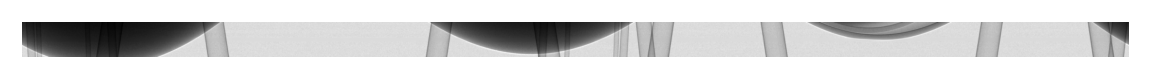

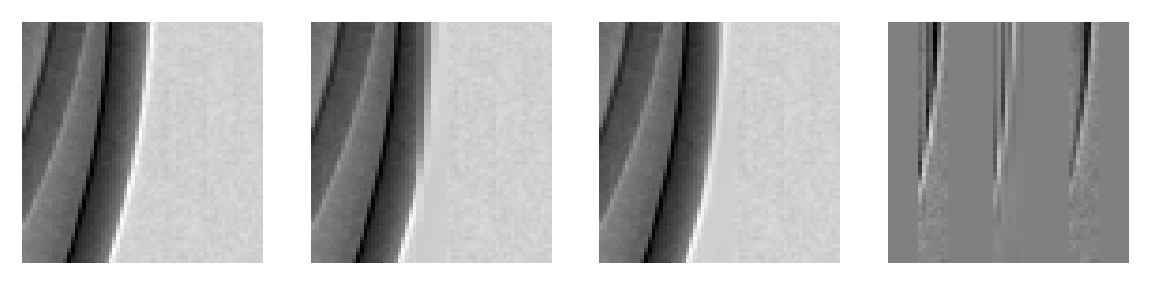

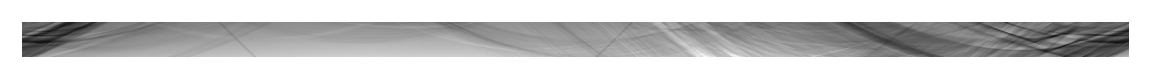

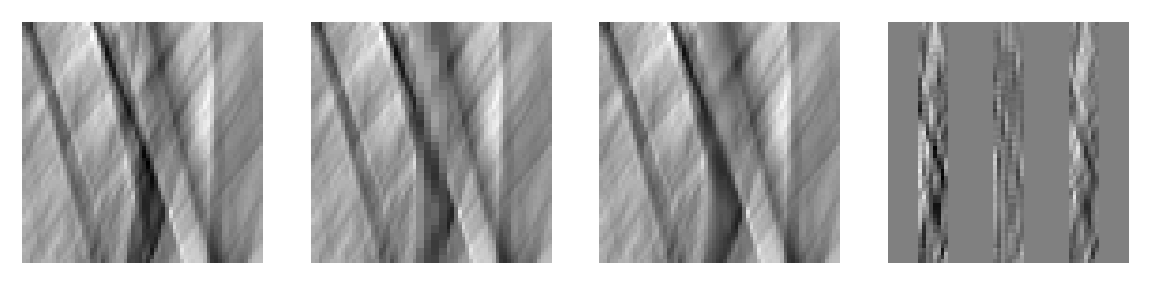

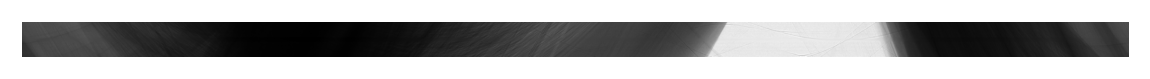

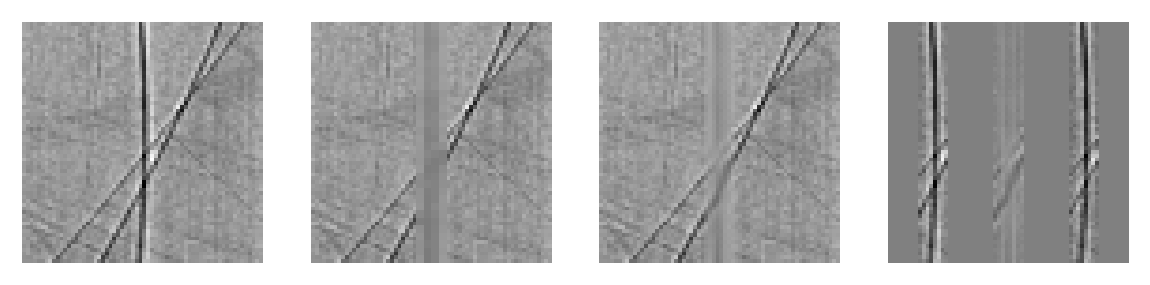

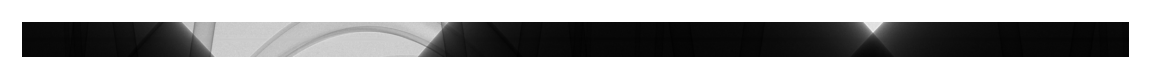

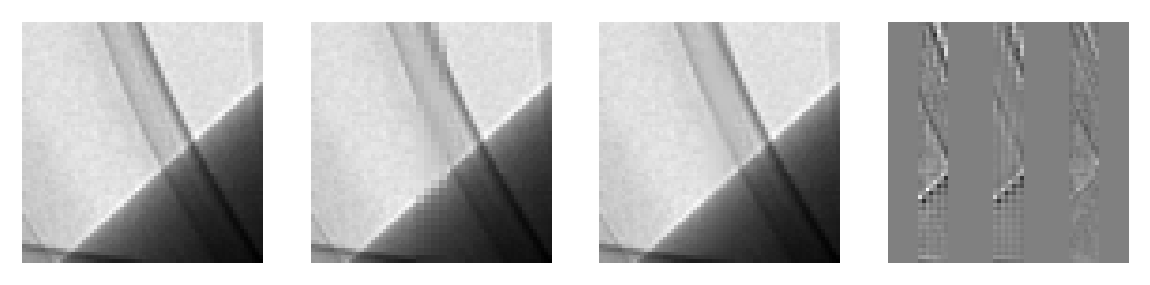

In [ ]:
#sg.optimizers_G[0].zero_grad(set_to_none=True)
#sg.load_model(sg.generator.lowResGenerator, model_path="model_2_gen.pt" )
sg.generator.eval()
with torch.no_grad() :
    _ = sg.displayImages()
    #_ = sg.summarizeMe(sg.testLoader, False)

## <font style="color:lightblue">Execute</font>

GLR : 1.115e-05 (1.121e-02). 
Epoch: 41 (19).  Images: 64. DIS: 0.000e+00, GEN: 7.655e-01. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: EAGLE: 7.775e-01  MSE: 7.534e-01  MSEN: 5.105e+00  L1L: 1.154e+00  L1LN: 3.137e+00  SSIM: 1.465e+00  MSSSIM: 3.100e-01  STD: 9.179e-01  COR: 3.026e+00 



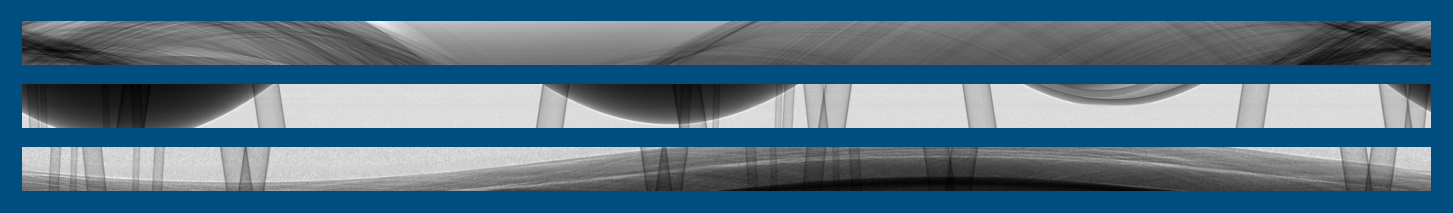

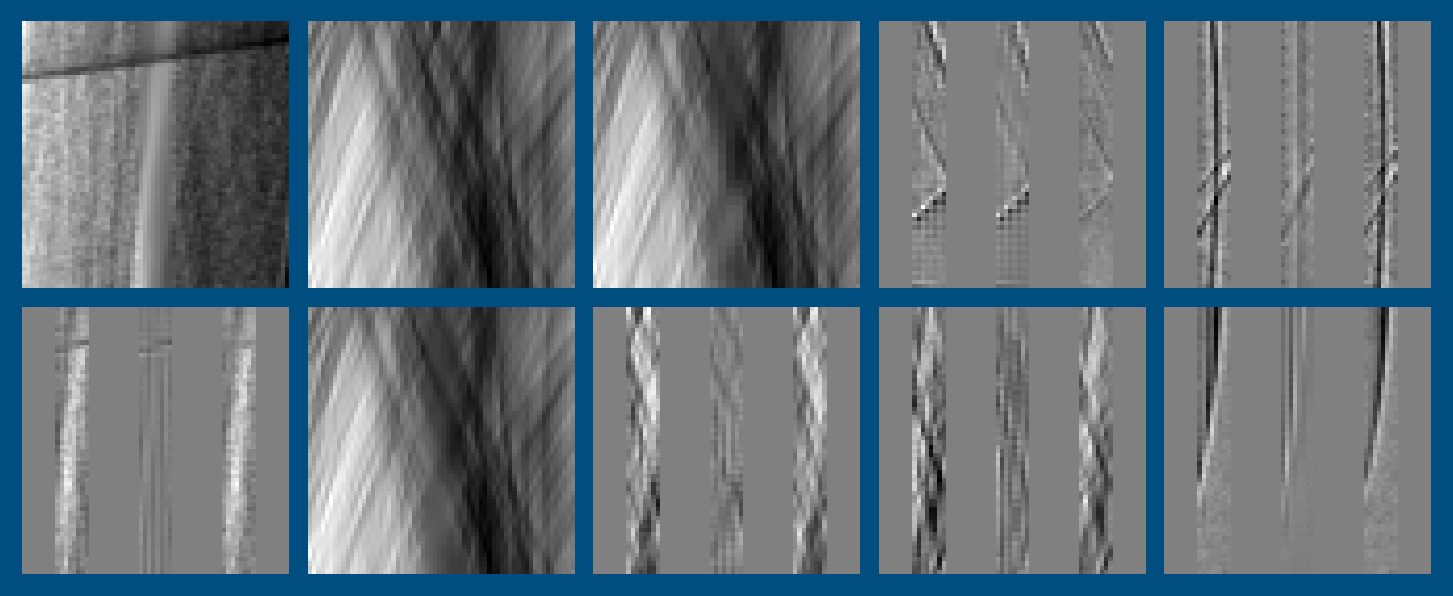

In [ ]:
sg.freeGPUmem()
sg.freeGPUmem()

#torch.optim.lr_scheduler.LambdaLR(sg.optimizers_G[0], lambda epoch: 0.01).step()
sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizers_G[0], 1, gamma=1-0.005)
def my_beforeReport(sglocals) :
    #return
    message = ""

    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.00001)
    sg.writer.add_scalars("Aux", {'LrnRate': sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG}, sg.imer)

    #for metrics in ('L1L','SSIM','MSSSIM') :
    #    sg.metrices[metrics].weight = max(0, sg.metrices[metrics].weight - 0.005)
    #    message += f"{metrics} weight: {sg.metrices[metrics].weight}. "
    #    sg.writer.add_scalars("Aux", {metrics: sg.metrices[metrics].weight}, sg.imer)

    print(message)
sg.beforeReport = my_beforeReport

def my_beforeEachEpoch(sglocals) :
    sg.TCfg.batchSize = int(min(2**12, sg.TCfg.batchSize * 2))
    sg.TCfg.batchSplit = max(2**0, int(sg.TCfg.batchSize / 2**4))
    sg.writer.add_scalars("Aux", {'Batch size': math.log(sg.TCfg.batchSize,2)}, sg.imer)
    print(f"Batch size: {sg.TCfg.batchSize}, split: {sg.TCfg.batchSplit}", )
    return
#sg.beforeEachEpoch = my_beforeEachEpoch

#sg.load_model(sg.generator.brickGenerator, model_path="saves/aio32/dbricks_2/model_gen.pt" )
#sg.TCfg.num_workers=
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoaderhuiVam
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.freeGPUmem()
    sg.epoch -= 1
    raise



## <font style="color:lightblue">Post</font>

In [ ]:
for param in sg.generator.stripeGenerator.fcMix.parameters() :
    if param.ndim == 2 :
        print(param.shape)
        sg.tensorStat(param)
        sg.tensorStat(param[:,8192:])
        sg.tensorStat(param[:,:8192])


torch.Size([8192, 16384])
1.768e-03, 6.414e-02, -6.884e-01, 6.776e-01
1.276e-03, 8.481e-02, -6.884e-01, 6.776e-01
2.260e-03, 3.217e-02, -3.162e-01, 2.448e-01


In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)


In [ ]:
sg.epoch += 1
for key in sg.resAcc.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices per epoch", {key : sg.resAcc.metrices[key],}, sg.epoch )

resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses epoch test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   #,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
for key in resTest.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices epoch test", {key : resTest.metrices[key],}, sg.epoch )
sg.writer.add_scalars("Probs epoch test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )





100%|██████████| 265/265 [11:08<00:00,  2.52s/it]

Images: 16960. DIS: 0.000e+00, GEN: 7.117e-01. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: EAGLE: 7.613e-01  MSE: 6.621e-01  MSEN: 6.461e-01  L1L: 8.208e-01  L1LN: 8.448e-01  SSIM: 7.213e-01  MSSSIM: 4.395e-01  STD: 7.675e-01  COR: 7.077e-01 



In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.save_model(sg.generator, "tmp2.pt")

In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.generator,
                           sg.optimizer_G, sg.optimizer_D)

